## Reference code
https://github.com/mil-tokyo/MCD_DA

In [1]:
from utils import *
np.random.seed(10)
torch.manual_seed(10)

In [2]:
dataset = sio.loadmat('2Moons_v2.mat')

X_,X_adapt_ = dataset['X'], dataset['X_adapt']
Y_,yt_ = dataset['Y'].squeeze()-1, (1-dataset['yt'].squeeze())/2

## Data plot

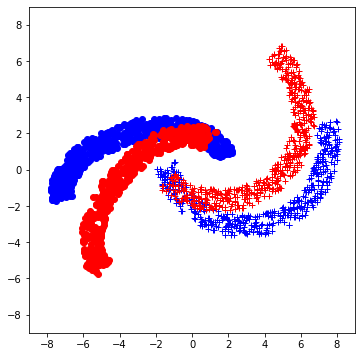

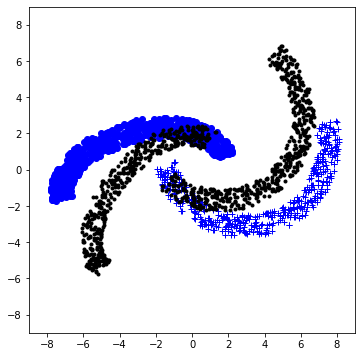

In [3]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
# Source domain
# label 1
plt.plot(X_[np.where(Y_==0)[0],0],X_[np.where(Y_==0)[0],1],'bo')
# label 2
plt.plot(X_[np.where(Y_==1)[0],0],X_[np.where(Y_==1)[0],1],'b+')

# Target domain
# label 1
plt.plot(X_adapt_[np.where(yt_==0)[0],0],X_adapt_[np.where(yt_==0)[0],1],'ro')
# label 2
plt.plot(X_adapt_[np.where(yt_==1)[0],0],X_adapt_[np.where(yt_==1)[0],1],'r+')

ax.set_aspect('equal')
plt.xlim([-9,9]), plt.ylim([-9,9])
# plt.savefig('./docs/dataset_labeled.png')

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
# Source domain
# label 1
plt.plot(X_[np.where(Y_==0)[0],0],X_[np.where(Y_==0)[0],1],'bo')
# label 2
plt.plot(X_[np.where(Y_==1)[0],0],X_[np.where(Y_==1)[0],1],'b+')

# Target domain
plt.plot(X_adapt_[:,0],X_adapt_[:,1],'k.')

ax.set_aspect('equal')
plt.xlim([-9,9]), plt.ylim([-9,9])
# plt.savefig('./docs/dataset_unlabeled.png')
plt.show()

## Dataset

In [4]:
X = torch.tensor(X_).type(torch.float32)
X_adapt = torch.tensor(X_adapt_).type(torch.float32)
Y = torch.LongTensor(Y_)
yt = torch.LongTensor(yt_)

In [5]:
batch_size = 32

x_train_source, x_test_source, y_train_source, y_test_source = train_test_split(X,Y,test_size = 0.2) 
train_source = DataLoader(TensorDataset(x_train_source,y_train_source), batch_size=batch_size, shuffle=True)

x_train_target, x_test_target, y_train_target, y_test_target = train_test_split(X_adapt,yt,test_size = 0.2) 
train_target = DataLoader(x_train_target, batch_size=batch_size, shuffle=True)

_____
># Domain adaptation

>### Model

In [6]:
class MCD_g(nn.Module):
    def __init__(self):
        super(MCD_g,self).__init__()
        self.hidden = nn.Linear(2,15)                
        
    def forward(self, x):
        h = self.hidden(x)
        h = F.relu(h)
        return h

class MCD_c(nn.Module):
    def __init__(self):
        super(MCD_c,self).__init__()
        self.out = nn.Linear(15,2)                
        
    def forward(self, x):
        y = self.out(x)        
        return y

In [7]:
model_g = MCD_g()
model_c1 = MCD_c()
model_c2 = MCD_c()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_g.to(device)
model_c1.to(device)
model_c2.to(device)

criterion = nn.CrossEntropyLoss()
opt_g = optim.Adam(model_g.parameters(), lr=1e-5) 
opt_c1 = optim.Adam(model_c1.parameters(), lr=1e-5) 
opt_c2 = optim.Adam(model_c2.parameters(), lr=1e-5) 
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer,[100],gamma = 0.1)

def discrepancy(out1, out2):
    return torch.mean(torch.abs(F.softmax(out1,dim=1) - F.softmax(out2,dim=1)))

# Hyperparameter for MCD
num_k = 4

>### Train

In [8]:
train_loss_s1, train_loss_s2, train_loss_d = [],[],[]
train_acc1, train_acc2 = [],[]
            
num_epochs = 400
for epoch in range(num_epochs):                        
    
    model_g.train(True), model_c1.train(True), model_c2.train(True)
    running_loss_s1,running_loss_s2,running_loss_d = 0.0,0.0,0.0
    running_corrects1, running_corrects2 = 0.0, 0.0
    
    for batch_idx, (source_data, target_data) in enumerate(zip(train_source,train_target)):    
        
        x_s,y_s = source_data
        x_s,y_s = Variable(x_s).cuda(),Variable(y_s).cuda()
        x_t = Variable(target_data).cuda()  
                      
        # Source only
        opt_g.zero_grad(), opt_c1.zero_grad(), opt_c2.zero_grad()
        feat_s = model_g(x_s)
        output_s1,output_s2 = model_c1(feat_s), model_c2(feat_s)                
        loss_s1 = criterion(output_s1, y_s)        
        loss_s2 = criterion(output_s2, y_s)        
        loss_s = loss_s1 + loss_s2        
        loss_s.backward()        
        opt_g.step(), opt_c1.step(), opt_c2.step()
        
        # Max. Discrepancy
        opt_g.zero_grad(), opt_c1.zero_grad(), opt_c2.zero_grad()
        feat_s = model_g(x_s)
        feat_t = model_g(x_t)
        output_s1,output_s2 = model_c1(feat_s), model_c2(feat_s)                
        output_t1,output_t2 = model_c1(feat_t), model_c2(feat_t)                       
        loss_s1 = criterion(output_s1, y_s)        
        loss_s2 = criterion(output_s2, y_s)         
        loss_s = loss_s1 + loss_s2
        loss_d = discrepancy(output_t1,output_t2)
        loss = loss_s - loss_d
        loss.backward()
        opt_c1.step(), opt_c2.step()
        
        # Min. Discrepancy
        for i in range(num_k):
            opt_g.zero_grad(), opt_c1.zero_grad(), opt_c2.zero_grad()
            feat_t = model_g(x_t)
            output_t1,output_t2 = model_c1(feat_t), model_c2(feat_t)                       
            loss_d = discrepancy(output_t1,output_t2)            
            loss_d.backward()
            opt_g.step()

        # statistics
        _, preds1 = torch.max(output_s1.data, 1)                                
        _, preds2 = torch.max(output_s2.data, 1)                                
        running_loss_s1 += loss_s1.data
        running_loss_s2 += loss_s2.data
        running_loss_d += loss_d.data      
        running_corrects1 += torch.sum(preds1 == y_s.data)          
        running_corrects2 += torch.sum(preds2 == y_s.data)          
    
#     scheduler.step()
    epoch_loss_s1 = running_loss_s1 / len(train_source.dataset)
    epoch_loss_s2 = running_loss_s2 / len(train_source.dataset)
    epoch_loss_d = running_loss_d / len(train_source.dataset)    
    epoch_acc1 = running_corrects1.cpu().numpy()/len(train_source.dataset)
    epoch_acc2 = running_corrects2.cpu().numpy()/len(train_source.dataset)

    train_loss_s1.append(epoch_loss_s1)
    train_loss_s2.append(epoch_loss_s2)
    train_loss_d.append(epoch_loss_d)    
    train_acc1.append(epoch_acc1)        
    train_acc2.append(epoch_acc2)        
    if (epoch+1) % 20 == 0:
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)    
        print('{} Acc. 1 & 2 : {:.2f}%, {:.2f}%'.format('train', 100*epoch_acc1, 100*epoch_acc2))
        print('Classification Loss: {:.4f} Discrepancy: {:.4f}'.format(epoch_loss_s1 + epoch_loss_s2, epoch_loss_d))

Epoch 20/400
----------
train Acc. 1 & 2 : 75.12%, 49.12%
Classification Loss: 0.0386 Discrepancy: 0.0125
Epoch 40/400
----------
train Acc. 1 & 2 : 77.50%, 65.25%
Classification Loss: 0.0340 Discrepancy: 0.0116
Epoch 60/400
----------
train Acc. 1 & 2 : 80.62%, 78.25%
Classification Loss: 0.0302 Discrepancy: 0.0106
Epoch 80/400
----------
train Acc. 1 & 2 : 83.12%, 90.38%
Classification Loss: 0.0270 Discrepancy: 0.0098


KeyboardInterrupt: 

In [ ]:
plt.plot((torch.stack(train_loss_s1)+torch.stack(train_loss_s2)).cpu().numpy())
plt.plot(torch.stack(train_loss_d).cpu().numpy())
plt.legend(['Class','Discrepancy'])

>### Test

In [ ]:
def acc_MCD(x,y):
    model_g.eval(), model_c1.eval(), model_c2.eval()
    feat_tmp = model_g(x.cuda())
    out_tmp1, out_tmp2 = model_c1(feat_tmp), model_c2(feat_tmp)
    _, preds1 = torch.max(out_tmp1.data, 1)                                    
    _, preds2 = torch.max(out_tmp2.data, 1)                                    
    running_corrects1 = torch.sum(preds1 == y.cuda().data)
    running_corrects2 = torch.sum(preds2 == y.cuda().data)
    acc1 = running_corrects1.cpu().numpy()/len(x)
    acc2 = running_corrects2.cpu().numpy()/len(x)
    return acc1,acc2

acc_source = acc_MCD(x_test_source,y_test_source)
acc_target = acc_MCD(x_test_target,y_test_target)
print('Source Acc. 1 & 2 : {:.2f}%, {:.2f}%'.format(100*acc_source[0],100*acc_source[1])) 
print('Target Acc. 1 & 2 : {:.2f}%, {:.2f}%'.format(100*acc_target[0],100*acc_target[1])) 

>### Visualization

In [ ]:
h = 0.01
x_range = np.arange(-9.5, 9.5, h)
xx, yy = np.meshgrid(x_range,x_range)

with torch.no_grad():
    feat = model_g(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float32).to(device))    
    out1, out2 = model_c1(feat), model_c2(feat)
    z1 = out1.max(1,keepdim = True)[1].cpu().numpy()
    z2 = out2.max(1,keepdim = True)[1].cpu().numpy()
z1 = z1.reshape(xx.shape)
z2 = z2.reshape(xx.shape)

In [ ]:
#===== Classification ======#
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

cntr  = plt.contourf(xx, yy, z1,levels=1,alpha=0.3,cmap=plt.cm.get_cmap('coolwarm', 2))
cntr  = plt.contourf(xx, yy, z2,levels=1,alpha=0.3,cmap=plt.cm.get_cmap('coolwarm', 2))

# Source domain
# label 1
plt.plot(X_[np.where(Y_==0)[0],0],X_[np.where(Y_==0)[0],1],'bo')
# label 2
plt.plot(X_[np.where(Y_==1)[0],0],X_[np.where(Y_==1)[0],1],'b+')

# Target domain
plt.plot(X_adapt_[:,0],X_adapt_[:,1],'k.')

ax.set_aspect('equal')
plt.xlim([-9,9]), plt.ylim([-9,9])
plt.colorbar(cntr)

# for i in range(model.hidden.out_features):
#     w = model.hidden.weight[i].detach().cpu().numpy()
#     b = model.hidden.bias[i].detach().cpu().numpy()
#     y_tmp = -1/w[1]*(w[0]*x_range+b)
#     plt.plot(x_range,y_tmp,'--')

plt.savefig('./docs/result_MCD_'+str(num_k)+'.png')
plt.show()